## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [1]:
!pip install gym-minigrid &>/dev/null

In [2]:
rm -rf uaas

In [3]:

!git clone https://github.com/kehemo/uaas

Cloning into 'uaas'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 62 (delta 27), reused 29 (delta 8), pack-reused 0
Receiving objects: 100% (62/62), 1.05 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [4]:
from uaas.foo import *
from uaas.blackjack import *

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [ ]:
from gym_minigrid.envs.doorkey import DoorKeyEnv
env = DoorKeyEnv5x5()
acmodel = ACModel(env.action_space.n, use_critic=True)
collect_experiences(env, acmodel, Config(), 'cpu')

In [6]:
import gym
env = gym.make('Blackjack-v1', natural=False, sab=False)

## Run Reinforce

Great!  Now let's run our implementation, and see how we do.

In [7]:
import torch
class UAASParameterUpdate:
    def __init__(self, alpha, epsilon):
        self.q_j = 0
        self.j = 1
        self.alpha = alpha
        self.epsilon = epsilon

    def step_size(self):
        return self.j ** (-0.5 + self.epsilon)

    def __call__(self, optimizer, acmodel, sb, args):
        """
        optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
        acmodel: Network used to compute policy. torch.nn.Module
        sb: stores experience data. Refer to "collect_experiences". dict
        args: Config arguments. Config

        return output logs : dict
        """
        dist, vals = acmodel(sb["obs"])
        logps = dist.log_prob(sb["action"])
        val_nograd = sb['value']
        reward = sb["discounted_reward"]
        val_t1 = torch.roll(val_nograd, shifts=-1, dims=0)
        val_t1[-1] = 0
        reduced_reward = sb["reward"] + args.discount * val_t1
        score = (val_nograd - reward) * (val_nograd - reward)
        indices = []
        for x in score[1:]:
            s = x.item()
            self.q_j += self.step_size() * ((1 if self.q_j <= s else 0) - self.alpha)
            indices.append(1 if self.q_j <= s else 0)
        indices.append(0)
        reward_prime = torch.stack([reward, reduced_reward])[indices]
        advantage = reward_prime - val_nograd
        # computes policy loss
        policy_loss = compute_policy_loss_with_baseline(logps, advantage)
        update_policy_loss = policy_loss.item()

        value_loss = torch.norm(reward - vals, p=2)
        update_value_loss = value_loss.item()

        loss = value_loss + policy_loss

        # Update actor-critic
        optimizer.zero_grad()
        loss.backward()

        # Perform gradient clipping for stability
        update_grad_norm = (
            sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
        )
        torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
        optimizer.step()

        # Log some values
        logs = {
            "policy_loss": update_policy_loss,
            "grad_norm": update_grad_norm,
            "value_loss": update_value_loss,
        }

        return logs

In [41]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
import random
from tqdm import tqdm
from dataclasses import dataclass


# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)


def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: a tuple of three floats
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """

    # player_sum, dealer_card, usable_ace = obss
    # return torch.tensor([player_sum, dealer_card, usable_ace, 1 if usable_ace else 0], device=device, dtype=torch.float).unsqueeze(0)
    return torch.tensor(obss, device=device, dtype=torch.float)


@dataclass
class Config:
    """
    Stores algorithmic hyperparameters.
    """

    score_threshold = 0.93
    discount = 0.995
    lr = 1e-6
    max_grad_norm = 0.5
    log_interval = 10
    max_episodes = 40000
    gae_lambda = 0.95
    use_critic = False
    clip_ratio = 0.2
    target_kl = 0.01
    train_ac_iters = 5
    use_discounted_reward = False
    entropy_coef = 0.01
    use_gae = False

class BlackjackACModel(nn.Module):
    def __init__(self, num_actions, use_critic=True):
        super(BlackjackACModel, self).__init__()
        self.use_critic = use_critic

        self.common = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions),
            nn.LogSoftmax(dim=-1)
        )

        if self.use_critic:
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )

    def forward(self, obs):
        x = self.common(obs)
        action_probs = self.actor(x)

        if self.use_critic:
            value = self.critic(x)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)

        return Categorical(logits=action_probs), value


def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """

    advantages = torch.zeros_like(values)
    #### TODO: populate GAE in advantages over T timesteps (10 pts) ############
    td = (rewards + discount * torch.roll(values, -1) - values)[:T]
    coeffs = torch.triu(
        (discount * gae_lambda)
        ** torch.cumsum(torch.triu(torch.ones((T, T)), diagonal=1), axis=1)
    ).to(td.device)
    advantages = coeffs @ td
    ############################################################################
    return advantages[:T]


def compute_discounted_return(rewards, discount, device=None):
    """
                rewards: reward obtained at timestep.  Shape: (T,)
                discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
    """
    returns = torch.zeros(*rewards.shape, device=device)
    #### TODO: populate discounted reward trajectory (10 pts) ############
    T = rewards.shape[0]
    coeffs = torch.triu(
        discount ** torch.cumsum(torch.triu(torch.ones((T, T)), diagonal=1), axis=1)
    ).to(rewards.device)
    returns = coeffs @ rewards
    ######################################################################

    return returns


def collect_experiences(env, acmodel, args, device=None):
    """
    Collects rollouts and computes advantages.

    -------
    env     : DoorKeyEnv

              The environement used to execute policies in.


    acmodel : ACModel

              The model used to evaluate observations to collect experiences

    args    : Config

              config arguments


    device  : torch.cuda.device

              the device torch tensors are evaluated on.

    -------

    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """

    MAX_FRAMES_PER_EP = 300
    shape = (MAX_FRAMES_PER_EP,)

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros(*shape, device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    obss = [None] * MAX_FRAMES_PER_EP

    obs, _ = env.reset()

    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction

        preprocessed_obs = preprocess_obss(obs, device=device)

        with torch.no_grad():
            dist, value = acmodel(preprocessed_obs)
        action_probs = torch.softmax(dist.logits, dim=-1)
        action = 0 if (action_probs[0] > action_probs[1]) else 1

        obss[T] = obs
        # update environment from taken action. We use the resulting observation,
        # reward, and whether or not environment is in the done/goal state.
        obs, reward, done, _, _ = env.step(action)
        # print(obs, reward, done)

        # reward = 1 if reward == 1 else 0
        # reward = obs[0]

        # Update experiences values
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        log_probs[T] = dist.logits[action]

        total_return += reward
        T += 1

        if done or T >= MAX_FRAMES_PER_EP - 1:
            break
        # if done:
        #     obs, _ = env.reset()
        #     if T < MAX_FRAMES_PER_EP - 1:
        #         continue
        #     else:
        #         break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)

    # dict containing information on the experience
    # print('observations: ', obss)
    exps = dict(
        obs=preprocess_obss([obss[i] for i in range(T)], device=device),
        action=actions[:T],
        value=values[:T],
        reward=rewards[:T],
        advantage=discounted_reward - values[:T],
        log_prob=log_probs[:T],
        discounted_reward=discounted_reward,
        advantage_gae=compute_advantage_gae(
            values, rewards, T, args.gae_lambda, args.discount
        ),
    )

    logs = {"return_per_episode": total_return, "num_frames": T}

    return exps, logs


def compute_policy_loss_reinforce(logps, returns):
    """
    Function for computing the policy loss for the REINFORCE algorithm. See
    4.2 of lecture notes.

                logps: log probabilities for each time step. Shape: (T,)
                returns: total return for each time step. Shape: (T,)

    ----
    return : tensor.float Shape: [T,]

             policy loss for each timestep
    """
    policy_loss = torch.tensor(0)

    #### TODO: complete policy loss (10 pts) ###
    # HINT:  Recall, that we want to perform gradient ASCENT to maximize returns
    policy_loss = -torch.mean(logps * returns)
    ############################################

    return policy_loss


def update_parameters_reinforce(optimizer, acmodel, sb, args):
    """
    optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
    acmodel: Network used to compute policy. torch.nn.Module
    sb: stores experience data. Refer to "collect_experiences". dict
    args: Config arguments. Config

    return output logs : dict
    """

    # logps is the log probability for taking an action for each time step. Shape (T,)
    logps, reward = None, None

    ### TODO: compute logps and reward from acmodel, sb['obs'], sb['action'], and sb['reward'] ###
    ### If args.use_discounted_reward is True, use sb['discounted_reward'] instead. ##############
    ### (10 pts) #########################################
    dist, val = acmodel(sb["obs"])
    logps = dist.log_prob(sb["action"])

    reward = sb["discounted_reward"] if args.use_discounted_reward else sb["reward"]
    ##############################################################################################

    # computes policy loss
    policy_loss = compute_policy_loss_reinforce(logps, reward)
    update_policy_loss = policy_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    policy_loss.backward()

    # Perform gradient clipping for stability
    for p in acmodel.parameters():
        if p.grad is None:
            print(
                "Make sure you're not instantiating any critic variables when the critic is not used"
            )
    update_grad_norm = (
        sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    )
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values
    logs = {"policy_loss": update_policy_loss, "grad_norm": update_grad_norm}

    return logs


def run_experiment(args, parameter_update, seed=0):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    args: Config arguments. dict
    paramter_update: function used to update model parameters
    seed: random seed. int

    return: DataFrame indexed by episode
    """

    # Initialize random seeds for reproducible results
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make('Blackjack-v1', natural=False, sab=False)

    acmodel = BlackjackACModel(env.action_space.n, use_critic=args.use_critic)
    acmodel.to(device)

    is_solved = False

    # Smooth reward taken from last SMOOTH_REWARD_WINDOW timesteps
    SMOOTH_REWARD_WINDOW = 5000

    pd_logs, rewards = [], [0] * SMOOTH_REWARD_WINDOW

    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes))  # show progess bar ()
    for update in pbar:
        # First collect experiences
        exps, logs1 = collect_experiences(env, acmodel, args, device)
        # update parameters from experiences
        logs2 = parameter_update(optimizer, acmodel, exps, args)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {
            "episode": update,
            "num_frames": num_frames,
            "smooth_reward": smooth_reward,
            "reward": logs["return_per_episode"],
            "policy_loss": logs["policy_loss"],
        }

        if args.use_critic:
            data["value_loss"] = logs["value_loss"]

        pd_logs.append(data)

        #         pbar.set_postfix(data)

        # Early terminate
        # if smooth_reward >= args.score_threshold:
        #     is_solved = True
        #     break

    if is_solved:
        print("Solved!")

    return pd.DataFrame(pd_logs).set_index("episode")











####################################################################################














def compute_policy_loss_with_baseline(logps, advantages):
    """
    Computes policy loss with added baseline term. Refer to 4.3 in Lecture Notes.
    logps:  computed log probabilities. shape (T,)
    advantages: computed advantages. shape: (T,)

    ---

    return policy loss computed with baseline term: tensor.float. Shape (,1)

           refer to 4.3- Baseline in lecture notes

    """
    policy_loss = 0

    ### TODO: implement the policy loss (5 pts) ##############
    policy_loss = compute_policy_loss_reinforce(logps, advantages)
    ##################################################

    return policy_loss


def update_parameters_with_baseline(optimizer, acmodel, sb, args):
    """
    Updates model parameters using value and policy functions

    optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
    acmodel: Network used to compute policy. torch.nn.Module
    sb: stores experience data. Refer to "collect_experiences". dict
    args: Config arguments
    """

    def _compute_value_loss(values, returns):
        """
        Computes the value loss of critic model. See 4.3 of Lecture Notes

        values: computed values from critic model shape: (T,)
        returns: discounted rewards. shape: (T,)


        ---
        computes loss of value function. See 4.3, eq. 11 in lecture notes : tensor.float. Shape (,1)
        """

        value_loss = 0

        ### TODO: implement the value loss (5 pts) ###############
        value_loss = torch.norm(returns - values, p=2)
        ##################################################

        return value_loss

    logps, advantage, values, reward = None, None, None, None

    dist, values = acmodel(sb["obs"])
    logps = dist.log_prob(sb["action"])
    advantage = sb["advantage_gae"] if args.use_gae else sb["advantage"]
    reward = sb["discounted_reward"]

    policy_loss = compute_policy_loss_with_baseline(logps, advantage)
    value_loss = _compute_value_loss(values, reward)
    loss = policy_loss + value_loss

    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    loss.backward()
    update_grad_norm = (
        sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    )
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
        "grad_norm": update_grad_norm,
    }

    return logs

  0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 40000/40000 [04:30<00:00, 147.82it/s]


<Axes: xlabel='num_frames'>

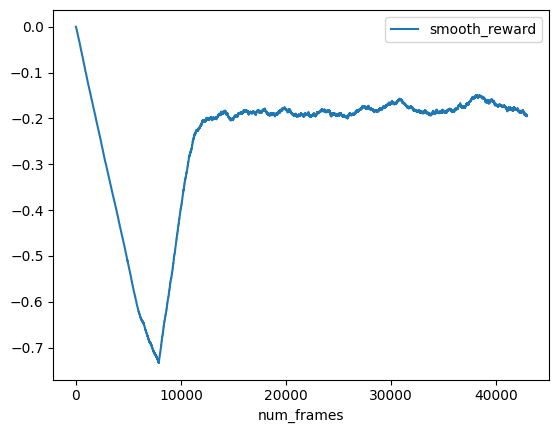

In [42]:
args = Config()
args.use_critic=True
df = run_experiment(args, UAASParameterUpdate(0.05, 0.1))

df.plot(x='num_frames', y=['smooth_reward'])

  0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 40000/40000 [04:28<00:00, 148.93it/s]


<Axes: xlabel='num_frames'>

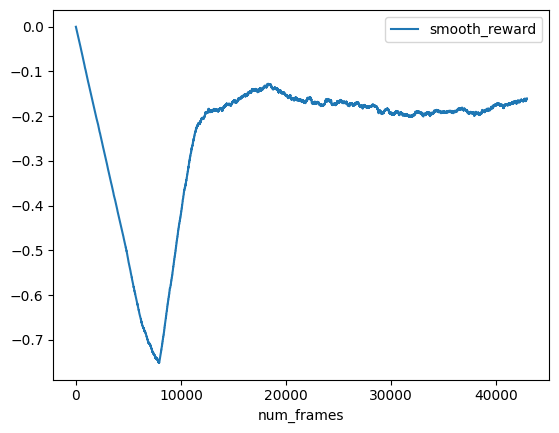

In [43]:
args = Config()
args.use_critic=True
df_baseline = run_experiment(args, update_parameters_with_baseline)

df_baseline.plot(x='num_frames', y=['smooth_reward'])

  0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 40000/40000 [04:19<00:00, 154.04it/s]


<Axes: xlabel='num_frames'>

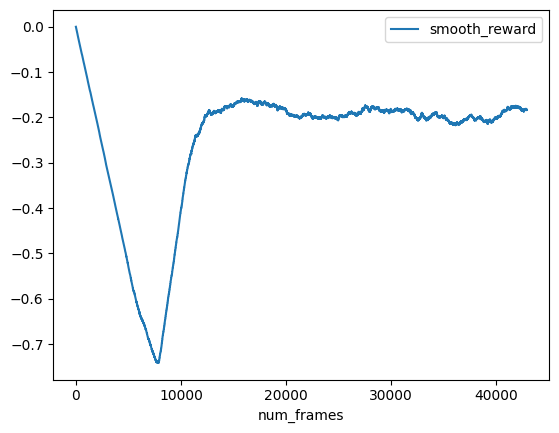

In [44]:
args = Config()
args.use_critic=True
args.use_gae=True
df_gae = run_experiment(args, update_parameters_with_baseline)

df_gae.plot(x='num_frames', y=['smooth_reward'])

# Old experiments

 29%|██▉       | 583/2000 [05:33<13:30,  1.75it/s]

Solved!


<Axes: xlabel='num_frames'>

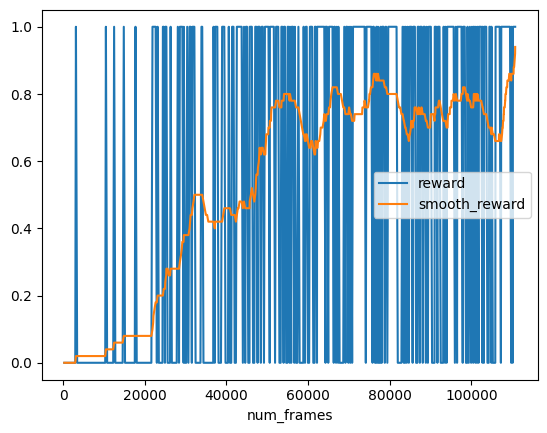

In [ ]:
args = Config()
args.use_critic=True
df = run_experiment(args, UAASParameterUpdate(0.05, 0.1))

df.plot(x='num_frames', y=['smooth_reward'])

In [ ]:
args = Config(use_critic=True)
df_baseline = run_experiment(args, update_parameters_with_baseline)

df_baseline.plot(x='num_frames', y=['reward', 'smooth_reward'])

In [ ]:
import torch
class UAASParameterUpdate:
    def __init__(self, alpha, epsilon):
        self.q_j = 0
        self.j = 1
        self.alpha = alpha
        self.epsilon = epsilon

    def step_size(self):
        return self.j ** (-0.5 + self.epsilon)

    def __call__(self, optimizer, acmodel, sb, args):
        """
        optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
        acmodel: Network used to compute policy. torch.nn.Module
        sb: stores experience data. Refer to "collect_experiences". dict
        args: Config arguments. Config

        return output logs : dict
        """
        dist, vals = acmodel(sb["obs"])
        logps = dist.log_prob(sb["action"])
        val_nograd = sb['value']
        advantage = sb["advantage"]
        reward = sb['discounted_reward']
        val_t1 = torch.roll(val_nograd, shifts=-1, dims=0)
        val_t1[-1] = 0
        reduced_advantage = sb["advantage_gae"] if args.use_gae else sb["reward"] + args.discount * val_t1 - val_nograd
        score = (val_nograd - reward) * (val_nograd - reward)
        indices = []
        for x in score[1:]:
            s = x.item()
            self.q_j += self.step_size() * ((1 if self.q_j <= s else 0) - self.alpha)
            indices.append(1 if self.q_j <= s else 0)
        indices.append(0)
        advantage = torch.stack([advantage, reduced_advantage])[indices]
        # computes policy loss
        policy_loss = compute_policy_loss_with_baseline(logps, advantage)
        update_policy_loss = policy_loss.item()

        value_loss = torch.norm(reward - vals, p=2)
        update_value_loss = value_loss.item()

        loss = value_loss + policy_loss

        # Update actor-critic
        optimizer.zero_grad()
        loss.backward()

        # Perform gradient clipping for stability
        update_grad_norm = (
            sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
        )
        torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
        optimizer.step()

        # Log some values
        logs = {
            "policy_loss": update_policy_loss,
            "grad_norm": update_grad_norm,
            "value_loss": update_value_loss,
            "quantile": self.q_j,
        }

        return logs

 17%|█▋        | 346/2000 [03:31<16:53,  1.63it/s]

Solved!


<Axes: xlabel='num_frames'>

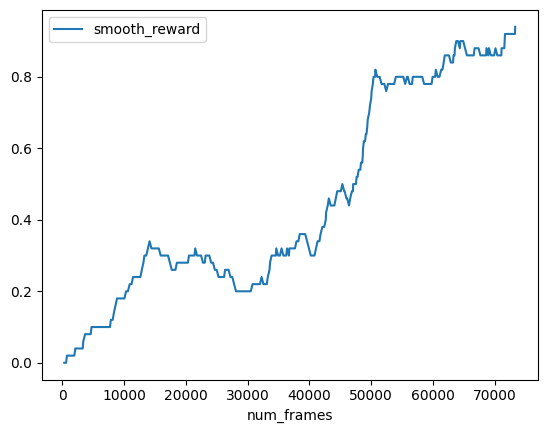

In [ ]:
def run_experiment(args, parameter_update, seed=0):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    args: Config arguments. dict
    paramter_update: function used to update model parameters
    seed: random seed. int

    return: DataFrame indexed by episode
    """

    # Initialize random seeds for reproducible results
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = DoorKeyEnv5x5()

    acmodel = ACModel(env.action_space.n, use_critic=args.use_critic)
    acmodel.to(device)

    is_solved = False

    # Smooth reward taken from last SMOOTH_REWARD_WINDOW timesteps
    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0] * SMOOTH_REWARD_WINDOW

    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes))  # show progess bar ()
    for update in pbar:
        # First collect experiences
        exps, logs1 = collect_experiences(env, acmodel, args, device)
        # update parameters from experiences
        logs2 = parameter_update(optimizer, acmodel, exps, args)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {
            "episode": update,
            "num_frames": num_frames,
            "smooth_reward": smooth_reward,
            "reward": logs["return_per_episode"],
            "policy_loss": logs["policy_loss"],
        }

        if args.use_critic:
            data["value_loss"] = logs["value_loss"]
            data['quantile'] = logs['quantile']

        pd_logs.append(data)

        #         pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break

    if is_solved:
        print("Solved!")

    return pd.DataFrame(pd_logs).set_index("episode")


args = Config()
args.use_critic=True
# args.use_gae = True
df = run_experiment(args, UAASParameterUpdate(0.05, 0.1))

df.plot(x='num_frames', y='smooth_reward')

<Axes: xlabel='num_frames'>

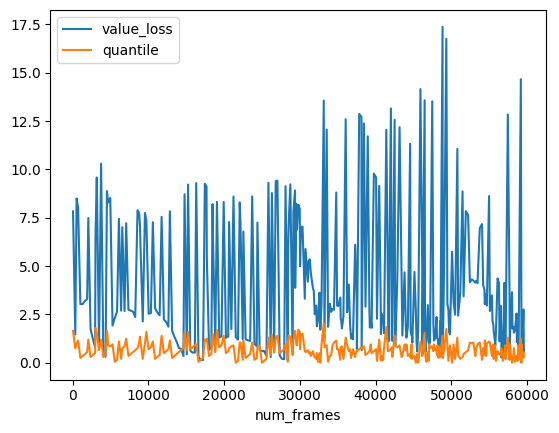

In [ ]:
df.plot(x='num_frames', y=['value_loss', 'quantile'])

## REINFORCE with Discounted Reward

Uh oh! Even after 300,000 steps, our policy does not converge. One reason for failure is the way rewards are generated in the real-world. In an ideal world, the agent would be rewarded at every timestep in a manner that perfectly corresponded to the quality of the action taken in a particular state.  However, this is rarely the case; for example, in Doorkey we only get reward at the very end of the episode (i.e., the sparse reward scenario).

Oh, the reward is binary and difficult to see the improvement since it depends on the density of the blue bar in the plot. So, we smooth reward by averaging certain amount of rewards from previous episode (`smooth_reward`).

Fill in `compute_discounted_return` code block above, then run code cell below to see the effect of discounted reward trajectories.  This should converge, so if it doesn't, you've made an error (although try re-running the cell a few times first to make sure it's not a bad random seed). **(10 pts)**



 32%|███▏      | 640/2000 [03:54<08:18,  2.73it/s]


Solved!


<Axes: xlabel='num_frames'>

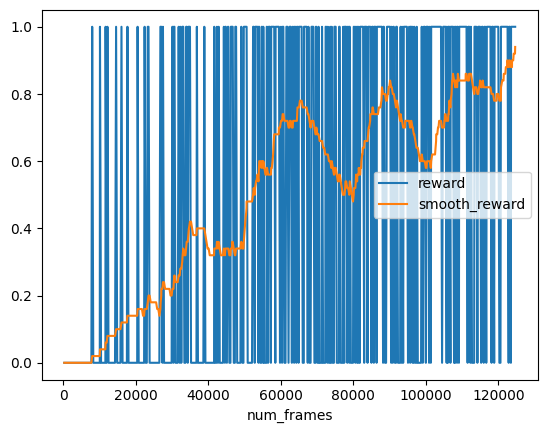

In [ ]:
args = Config(use_discounted_reward=True)
df = run_experiment(args, update_parameters_reinforce)

df.plot(x='num_frames', y=['reward', 'smooth_reward'])

## Run REINFORCE with baseline

If you did everything right, you should be able to run the below cell to run the vanilla policy gradients implementation with baseline.  This should be somewhat more stable than without the baseline, and likely converge faster.


 23%|██▎       | 466/2000 [04:00<13:12,  1.94it/s]

Solved!


<Axes: xlabel='num_frames'>

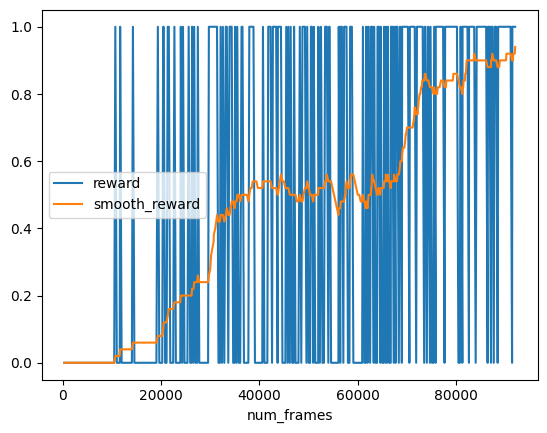

In [ ]:
args = Config(use_critic=True)
df_baseline = run_experiment(args, update_parameters_with_baseline)

df_baseline.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Reinforce with GAE

The advantage we computed above seemed to work, and hopefully improved our results! Fortunately, we can do even better. The paper Generalized Advantage Estimation describes a nifty method for building a strong advantage estimate (see formula 16 in the paper) that empirically outperforms a naive subtraction (and includes reward shaping). Implemented the GAE function we left blank from earlier.

 28%|██▊       | 563/2000 [04:31<11:32,  2.08it/s]

Solved!


<Axes: xlabel='num_frames'>

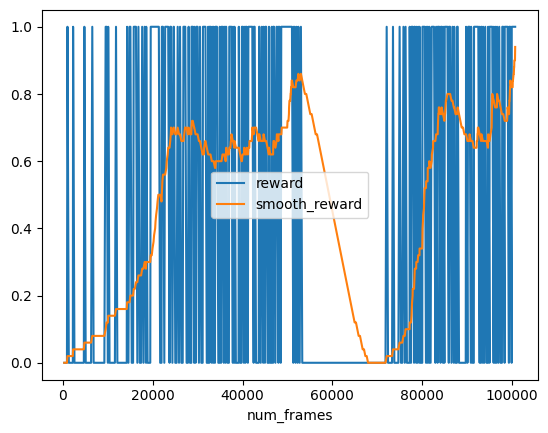

In [ ]:
args = Config(use_critic=True, use_gae=True)
df_gae = run_experiment(args, update_parameters_with_baseline)

df_gae.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Fancy Plots
If you've gotten to this point, congrats: you've succesfully implemented REINFORCE, VPG, and GAE!

**(10 pts)** Now let's visualize every result in one plot.

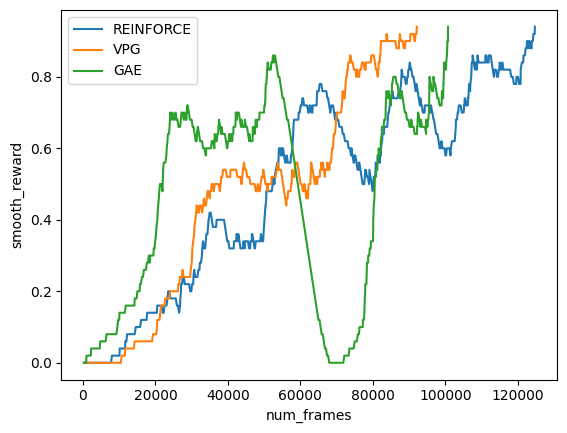

In [ ]:
# TODO Visualize all results into one plot.

# plot(df['num_frames'], df['smooth_reward'])

ax = None
for t, name in ((df, 'REINFORCE'), (df_baseline, 'VPG'), (df_gae, 'GAE')):
  t = t.rename(columns={'smooth_reward': name})
  ax = t.plot(ax=ax, x='num_frames', y=name, ylabel='smooth_reward')